# Analysis of run739HF data

A quick exploratory analysis of run739HF dataset obtained from Victor. 
Dataset is provided by Karl.

## Import modules and define functions

In [42]:
%matplotlib inline
import scipy
import pynbody as pb
from scipy import stats as st
from matplotlib.colors import LogNorm
from matplotlib.pylab import *

base_dir = '/home/ubuntu/projects/S2B/shared/'
data_fname1 = base_dir + 'run739HF/run739HF.01300'
data_fname2 = base_dir + 'run739HF/run739HF.01400'
data_fname3 = base_dir + 'run739HF/run739HF.01500'
param_fname = base_dir + 'run739HF/run739HF.param'

def pbload(filename, paramname=None):
    print('Loading data from file', filename, '...')
    if '::' in filename:
        filename, species = filename.split('::')
        sim = pb.load(filename, paramname=paramname)
        sim = getattr(sim, species)
    else:
        sim = pb.load(filename, paramname=paramname)
    print('Done!')
    return sim

def Gauss_Hermite(w, n):
    """
    Return the Gauss Hermite function of order n, weights w
    Gerhard MNRAS (1993) 265, 213-230
    Equations 3.1 - 3.7
    @author: Steven Gough-Kelly
    """
    w = np.array(w)
    p = scipy.special.hermite(n, monic=False) #hermite poly1d obj
    norm = np.sqrt((2**(n+1))*np.pi*np.math.factorial(n)) # N_n Eqn 3.1
    return (p(w)/norm) * np.exp( -0.5 * w * w )

def GaussHermiteMoment(v, n):
    v = v[np.isfinite(v)] # remove nans&inf
    if len(v) <= 1: # Added SL speed+error catch
        return np.nan
    v_dash = (v - np.mean(v))/np.std(v) # center on 0, norm width to 1sig
    hn = np.sum(Gauss_Hermite(v_dash, n))
    return np.sqrt(4*np.pi) * hn / len(v)

def plot_image ():
    image = plt.imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    xcent = (xedges[1:] + xedges[:-1]) / 2
    ycent = (yedges[1:] + yedges[:-1]) / 2

    plt.title(plt_title)  
    cbar = plt.colorbar()
    cbar.set_label(cbar_label)
    axes = plt.gca()
    axes.set_aspect(1)
    # axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
    axes.set_xlabel('x [kpc]')
    axes.set_ylabel('y [kpc]')
    axes.set_xlim(-xlim, xlim)
    axes.set_ylim(-ylim, ylim)
    plt.show()

def load_data_lst():
    s1 = pbload(data_fname1,param_fname)
    pb.analysis.angmom.faceon(s1)

    s2 = pbload(data_fname2,param_fname)
    pb.analysis.angmom.faceon(s2)

    s3 = pbload(data_fname3,param_fname)
    pb.analysis.angmom.faceon(s3)

    # Combining 3 time stapshots in a list
    s_lst = [s1,s2,s3]
    return(s_lst)


## Load data

Loading a simulation output using the `pynbody.load()` function, which tries to automatically determine which type of code output you have:

In [105]:
s_lst = load_data_lst()
for s in s_lst:
    pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.01900 ...
Done!


KeyboardInterrupt: 

Note that the above assumes you have downloaded and unpacked the test data in the above folder.

## Data exploration

### General dataset properties

In [7]:
for s in s_lst:
    print(s)

<SimSnap "/home/ubuntu/projects/S2B/shared/run739HF/run739HF.00100" len=10677788>
<SimSnap "/home/ubuntu/projects/S2B/shared/run739HF/run739HF.00200" len=11351979>
<SimSnap "/home/ubuntu/projects/S2B/shared/run739HF/run739HF.00300" len=12114922>


In [8]:
for s in s_lst:
    print(len(s))

10677788
11351979
12114922


`stars`, `gas`, `dark` also available as `s`, `g`, `d`

In [9]:
for s in s_lst:
    print(len(s.star), len(s.gas), len(s.dark))

856912 4820876 5000000
1708826 4643153 5000000
2730125 4384797 5000000


The `properties` attribute of a `SimSnap` tells us some more basic info 

In [10]:
for s in s_lst:
    print(s.properties)

{'time': Unit("4.99e-01 s kpc km**-1")}
{'time': Unit("9.99e-01 s kpc km**-1")}
{'time': Unit("1.50e+00 s kpc km**-1")}


In [11]:
for s in s_lst:
    print(s.properties['time'].in_units('Gyr'))

0.48832099041489285
0.9766419808297857
1.4649629712446677


Which quantities do we have available?

In [12]:
for s in s_lst:
    print(s.keys())

['pos', 'x', 'y', 'z', 'vel', 'vx', 'vy', 'vz', 'mass', 'eps', 'phi']
['pos', 'x', 'y', 'z', 'vel', 'vx', 'vy', 'vz', 'mass', 'eps', 'phi']
['pos', 'x', 'y', 'z', 'vel', 'vx', 'vy', 'vz', 'mass', 'eps', 'phi']


None! Because pynbody "lazy-loads" data... so lets see which data is actually on-disk:

In [13]:
for s in s_lst:
    print(s.loadable_keys())

['mass', 'pos', 'eps', 'phi', 'vel']
['mass', 'pos', 'eps', 'phi', 'vel']
['mass', 'pos', 'eps', 'phi', 'vel']


vel - velocity components vx, vy, vz - **km/s ?**, 
**phi - ?**, 
**eps - ?**, 
pos - position components x, y, z - kpc, 
mass - particle mass, **units?**

By default everything is in system units, but most of the time thinking in physical units is easier: But aparently there is no physical units defined in this dataset.

In [14]:
for s in s_lst:
    print(s.physical_units())

None
None
None


### Dataset components

To access any of these arrays or vectors, you access them like a python dictionary: 

In [15]:
for s in s_lst:
    print(s.star['pos'])

[[ 2.80111735e+00  1.90891874e+00 -2.78044102e-01]
 [ 1.48543170e-01  1.07344347e-01  1.21688891e-02]
 [-7.47675408e-03  4.86875419e-02 -9.53125485e-03]
 ...
 [ 4.04984907e+00  9.39152277e-01  2.37858699e-01]
 [ 4.61237954e+00  2.16075815e+00  9.17214680e-01]
 [ 4.21005623e+00  9.91833398e-01  1.81374014e+01]]
[[-4.15148612 -2.08922184 -0.36210664]
 [-0.14053582 -0.03448461  0.01318054]
 [ 0.01083723 -0.04247979  0.02688628]
 ...
 [ 3.21105473  2.98663919  1.07368829]
 [ 1.56925128  4.57735882 10.36300299]
 [ 1.60893817  4.48768697 10.3658795 ]]
[[ 1.08621514  3.78702009  0.34769491]
 [ 0.24967875 -0.28016404  0.08129565]
 [ 0.01344984 -0.02776753 -0.09971745]
 ...
 [ 6.57849155  2.35676909  0.62516681]
 [ 2.39885504  6.03118778  0.66716484]
 [ 4.42881506  3.27854646  0.63202234]]


Note that each array has units attached...

In [16]:
for s in s_lst:
    print(s.star['vel'])

[[ -87.63124176    6.08124624  -12.23198922]
 [ -65.97357724  237.83459403 -149.46133077]
 [ -47.13856104  123.8555126  -202.72012607]
 ...
 [-149.19444072   64.16794993   45.64273784]
 [ -83.59697331   46.44100771  -28.30229013]
 [  29.48747578  -44.5630538     2.80278724]]
[[ -42.69930131 -110.35129927  -29.99160608]
 [-108.87457751 -323.39850653   52.26122379]
 [-108.128934   -118.99817097  185.49078684]
 ...
 [-140.88143715   69.17778768  -26.63156196]
 [  -9.35196081  -47.28895634  -80.63690056]
 [ -12.94163597  -47.35830977  -56.43791857]]
[[ -71.99501152  -58.67861201   -0.96499779]
 [ 176.37961507  173.62157741  -10.72887949]
 [ 174.47033074  220.45339282  -32.73981019]
 ...
 [ -74.92463806  127.08890499  -40.25202531]
 [-159.77560544    5.28987394  -38.11801163]
 [-160.35531466   67.41211824    3.30045571]]


We have defined many useful quantities that are automatically calculated for you. For example, the radial and tangential velocities are simply obtained by

In [17]:
for s in s_lst:
    print(s.star['vt'],s.star['vr'])

[ 57.22371278 278.42395078 176.61332858 ... 109.86513465  79.56537548
  53.04751346] [ -67.7590167    75.74034616  165.72692485 ... -128.02116484  -60.12979125
    7.01383799]
[ 82.66680528 290.30941933 174.67018197 ... 147.13763092  11.22882706
  21.2307102 ] [ 89.81277929 186.79385486 172.4806963  ... -60.76926279 -93.27340316
 -71.72719877]
[ 53.3363855  247.31743146 282.99753815 ... 149.71724582 153.86462869
 150.18928283] [-76.04355589 -14.26245781  -4.88705261 ... -31.149045   -57.74846933
 -87.81966156]


We can try to access individual position and velocity components.

In [18]:
for s in s_lst:
    print(s.star['x'],s.star['y'],s.star['z'])

[ 2.80111735  0.14854317 -0.00747675 ...  4.04984907  4.61237954
  4.21005623] [1.90891874 0.10734435 0.04868754 ... 0.93915228 2.16075815 0.9918334 ] [-2.78044102e-01  1.21688891e-02 -9.53125485e-03 ...  2.37858699e-01
  9.17214680e-01  1.81374014e+01]
[-4.15148612 -0.14053582  0.01083723 ...  3.21105473  1.56925128
  1.60893817] [-2.08922184 -0.03448461 -0.04247979 ...  2.98663919  4.57735882
  4.48768697] [-0.36210664  0.01318054  0.02688628 ...  1.07368829 10.36300299
 10.3658795 ]
[1.08621514 0.24967875 0.01344984 ... 6.57849155 2.39885504 4.42881506] [ 3.78702009 -0.28016404 -0.02776753 ...  2.35676909  6.03118778
  3.27854646] [ 0.34769491  0.08129565 -0.09971745 ...  0.62516681  0.66716484
  0.63202234]


In [19]:
for s in s_lst:
    print(s.star['vx'],s.star['vy'],s.star['vz'])

[ -87.63124176  -65.97357724  -47.13856104 ... -149.19444072  -83.59697331
   29.48747578] [  6.08124624 237.83459403 123.8555126  ...  64.16794993  46.44100771
 -44.5630538 ] [ -12.23198922 -149.46133077 -202.72012607 ...   45.64273784  -28.30229013
    2.80278724]
[ -42.69930131 -108.87457751 -108.128934   ... -140.88143715   -9.35196081
  -12.94163597] [-110.35129927 -323.39850653 -118.99817097 ...   69.17778768  -47.28895634
  -47.35830977] [-29.99160608  52.26122379 185.49078684 ... -26.63156196 -80.63690056
 -56.43791857]
[ -71.99501152  176.37961507  174.47033074 ...  -74.92463806 -159.77560544
 -160.35531466] [-58.67861201 173.62157741 220.45339282 ... 127.08890499   5.28987394
  67.41211824] [ -0.96499779 -10.72887949 -32.73981019 ... -40.25202531 -38.11801163
   3.30045571]


## Working with density profiles

Text(0, 0.5, '$\\rho_{DM}$ [M$_{\\odot}$ kpc$^{-3}$]')

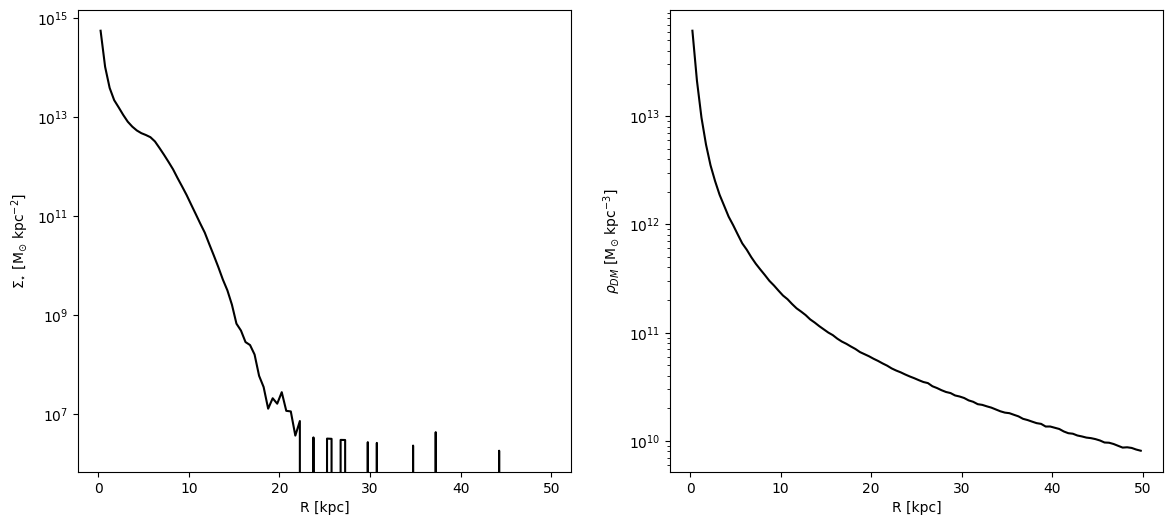

In [24]:
for s in s_lst:
    # center on the largest halo and align the disk
    pb.analysis.angmom.faceon(s)

    # convert all units to something reasonable (kpc, Msol etc)
    s.physical_units()

    # create a profile object for the stars (by default this is a 2D profile)
    p = pb.analysis.profile.Profile(s.star, vmin =.01, max=50)

    # Checking derivable keys
    p.derivable_keys()

    # make the figure and sub plots
    f, axs = plt.subplots(1,2,figsize=(14,6))

    # make the plot
    axs[0].plot(p['rbins'],p['density'], 'k')
    axs[0].semilogy()
    axs[0].set_xlabel('R [kpc]')
    axs[0].set_ylabel(r'$\Sigma_{\star}$ [M$_{\odot}$ kpc$^{-2}$]')

    # make a 3D density plot of the dark matter (note ndim=3 in the constructor below)
    p = pb.analysis.profile.Profile(s.dark,min=.01,max=50,ndim=3)

    axs[1].plot(p['rbins'],p['density'], 'k')
    axs[1].semilogy()
    axs[1].set_xlabel('R [kpc]')
    axs[1].set_ylabel(r'$\rho_{DM}$ [M$_{\odot}$ kpc$^{-3}$]')

## Rendering simple images with pynbody built-in functions

We render some simple images with pynbody image function, faceon, edgeon.

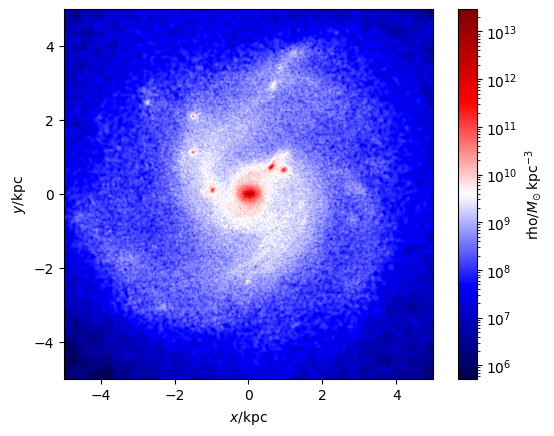

In [20]:
import pynbody.plot.sph as sph
cmap = 'seismic'

# s = pbload(data_fname00200,param_fname)
for s in s_lst:
    pb.analysis.angmom.faceon(s)
    sph.image(s.star,qty="rho",width=10,cmap=cmap)

Rotate 70 degrees clockwise about Z axis.

SimArray([[0.7417013 , 0.7681598 , 0.7946181 , ..., 1.9675367 ,
           2.0267909 , 2.0860453 ],
          [0.7280967 , 0.75246453, 0.7768322 , ..., 1.9637189 ,
           2.025992  , 2.0882652 ],
          [0.71449214, 0.73676926, 0.75904644, ..., 1.9599009 ,
           2.025193  , 2.0904849 ],
          ...,
          [0.30664632, 0.32316402, 0.33968168, ..., 0.40743554,
           0.40772393, 0.4080123 ],
          [0.28240484, 0.2973231 , 0.31224138, ..., 0.40727177,
           0.40769202, 0.4081122 ],
          [0.25816345, 0.27148226, 0.28480107, ..., 0.40710804,
           0.40766007, 0.4082121 ]], dtype=float32, '2.33e+05 Msol kpc**-3')

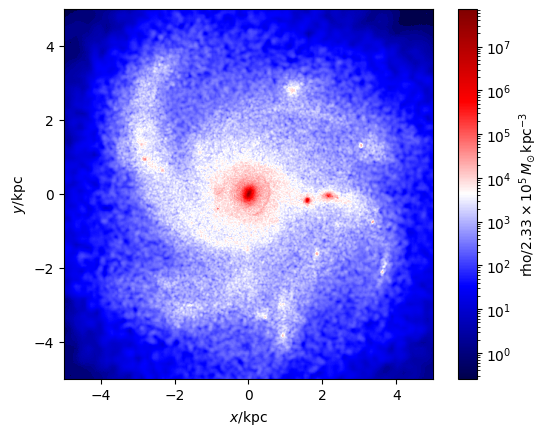

In [126]:
for s in s_lst:
    s.rotate_z(-170)
    sph.image(s.star,qty="rho",width=10,cmap=cmap)

Let us rotate 90 clockwise about X axis to get an edge-on view.

SimArray([[0.16528651, 0.16091229, 0.1565381 , ..., 0.2287083 ,
           0.22113608, 0.21356386],
          [0.16560663, 0.16121861, 0.15683055, ..., 0.24095961,
           0.23266667, 0.22437373],
          [0.16592678, 0.1615249 , 0.15712301, ..., 0.25321093,
           0.24419726, 0.2351836 ],
          ...,
          [0.18421993, 0.18697317, 0.18972641, ..., 0.10268491,
           0.10312499, 0.10356507],
          [0.18212204, 0.18492039, 0.18771873, ..., 0.10270346,
           0.10314707, 0.10359067],
          [0.18002416, 0.1828676 , 0.18571103, ..., 0.10272202,
           0.10316915, 0.10361628]], dtype=float32, '2.33e+05 Msol kpc**-3')

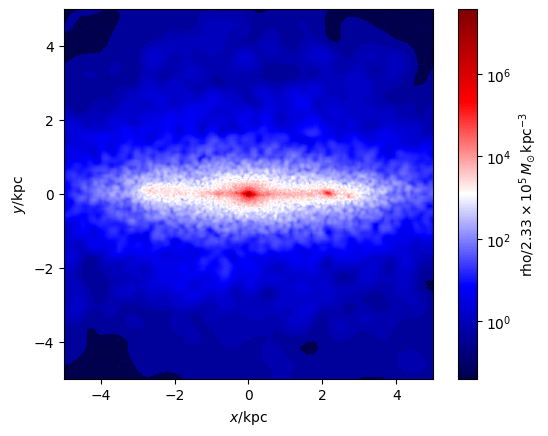

In [127]:
for s in s_lst:
    s.rotate_x(-90)
    sph.image(s.star,qty="rho",width=10,cmap=cmap)

## Binned 2d-statistics for number density and velocity

### Number density

#### Load data

In [43]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s_lst = load_data_lst()
for s in s_lst:
    pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.01300 ...
Done!
Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.01400 ...
Done!
Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.01500 ...
Done!


In [44]:
# Define global variables

bins = 50
# xlim, ylim = 25, 25 #Full view
cmap = 'seismic'

#### Face-on number density

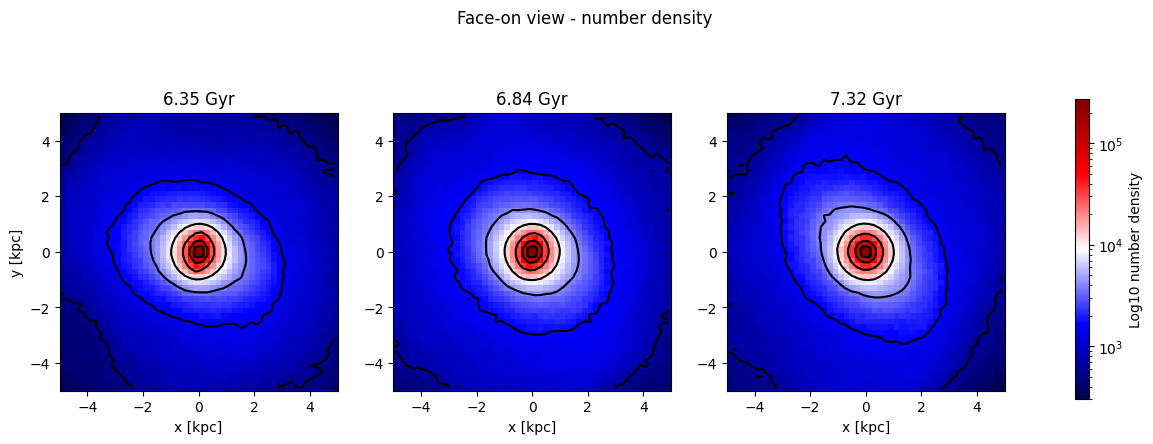

In [46]:
# Zoom in
#xlim, ylim = 0.5, 0.5 #kpc
#xlim, ylim = 1, 1 #kpc
xlim, ylim = 5, 5 #kpc
plt_title = 'Face-on view - number density'
cbar_label = 'Log10 number density'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
    
    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')

    xcent = (xedges[1:] + xedges[:-1]) / 2
    ycent = (yedges[1:] + yedges[:-1]) / 2
    axes[i].contour(xcent, ycent, np.log10(stat2d.T), colors='k')
    
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()


#### Inclination 60 deg - number density

Rotate 60 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [18]:
for s in s_lst:
    s.rotate_x(-60)

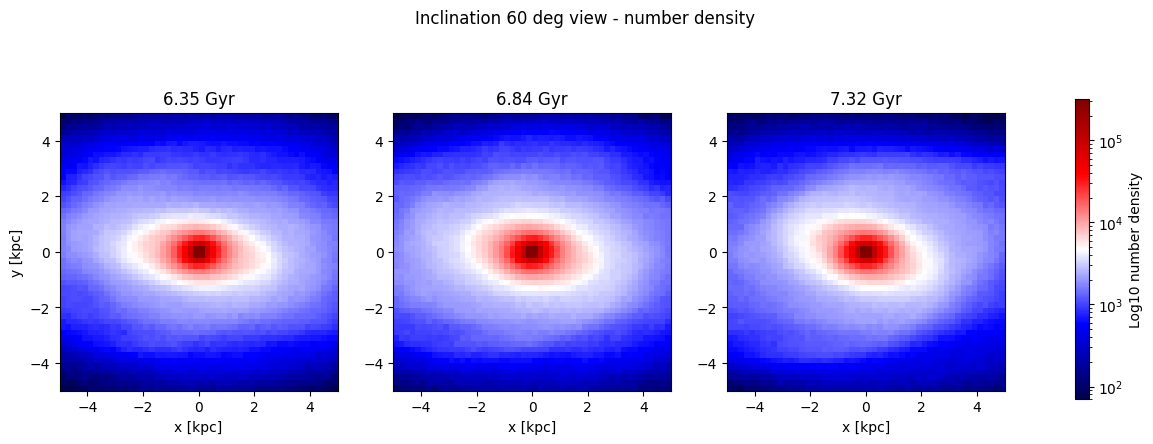

In [19]:
# Zoom in
xlim, ylim = 5, 5 #kpc
plt_title = 'Inclination 60 deg view - number density'
cbar_label = 'Log10 number density'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Edge-on - number density

Rotate 60 + 30 = 90 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [20]:
for s in s_lst:
    s.rotate_x(-30)

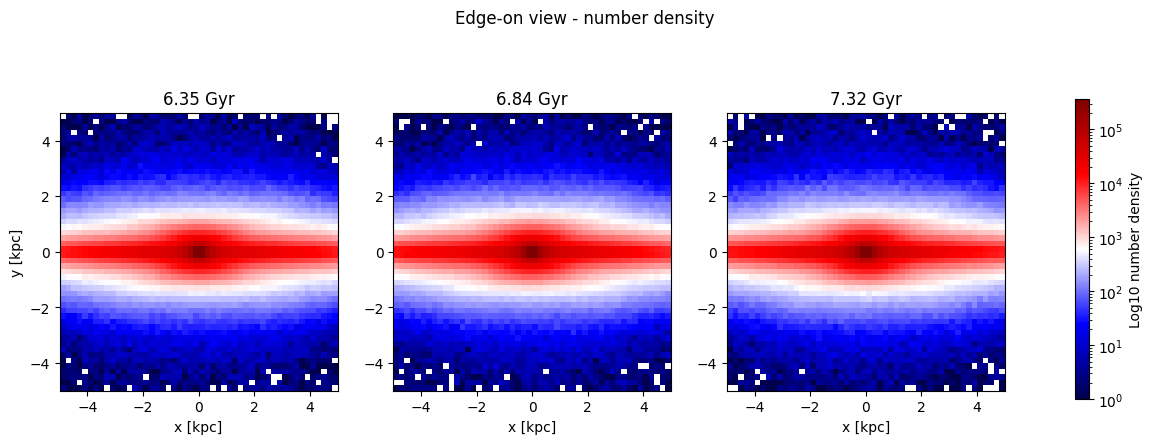

In [21]:
# Zoom in
xlim, ylim = 5, 5 #kpc
plt_title = 'Edge-on view - number density'
cbar_label = 'Log10 number density'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

### Velocity distribution

#### Load data

In [85]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s_lst = load_data_lst()
for s in s_lst:
    pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.00100 ...
Done!
Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.00200 ...
Done!
Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.00300 ...
Done!


#### Basic velocity distribution histograms

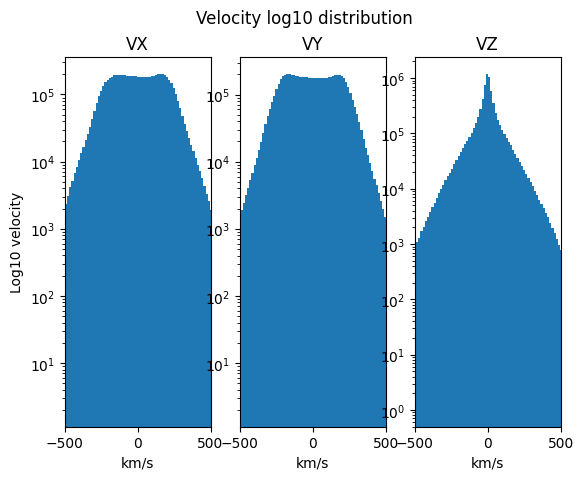

In [37]:

for s in s_lst:
# Extracting position and velocity components

    x = s.star['pos'][:,0]
    y = s.star['pos'][:,1]
    z = s.star['pos'][:,2]
    vx = s.star['vel'][:,0]
    vy = s.star['vel'][:,1]
    vz = s.star['vel'][:,2]

    x_lim = 500
    bins = 100

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Velocity log10 distribution')
    ax1.hist(vx, log = True, bins = bins)
    ax1.set_title('VX')
    ax1.set_xlim(-x_lim, x_lim)
    ax1.set_xlabel('km/s')
    ax1.set_ylabel('Log10 velocity')
    ax2.hist(vy, log = True, bins = bins)
    ax2.set_title('VY')
    ax2.set_xlim(-x_lim, x_lim)
    ax2.set_xlabel('km/s')
    ax3.hist(vz, log = True, bins = bins)
    ax3.set_title('VZ')
    ax3.set_xlim(-x_lim, x_lim)
    ax3.set_xlabel('km/s')
    
plt.show()

#### Face-on - mean velocity

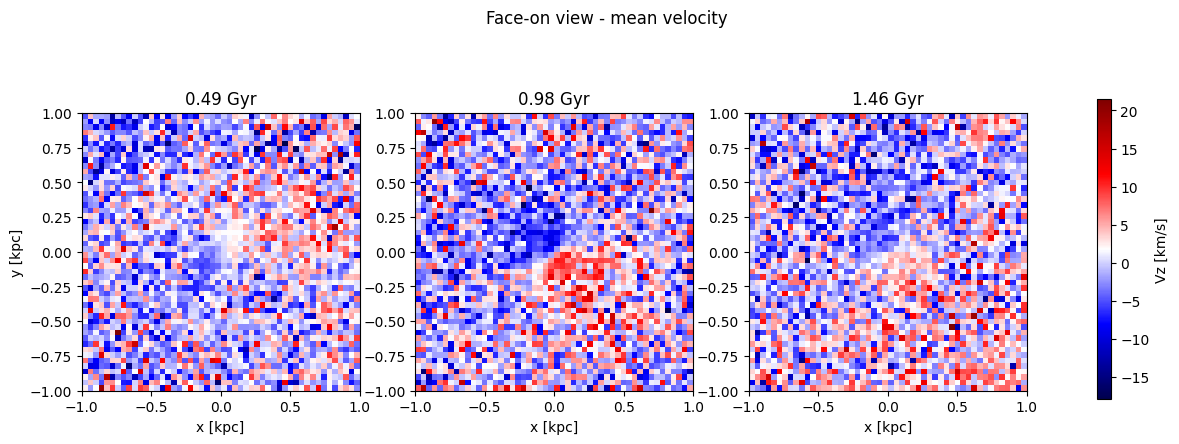

In [92]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Face-on view - mean velocity'
cbar_label = 'Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Face-on - velocity dispersion

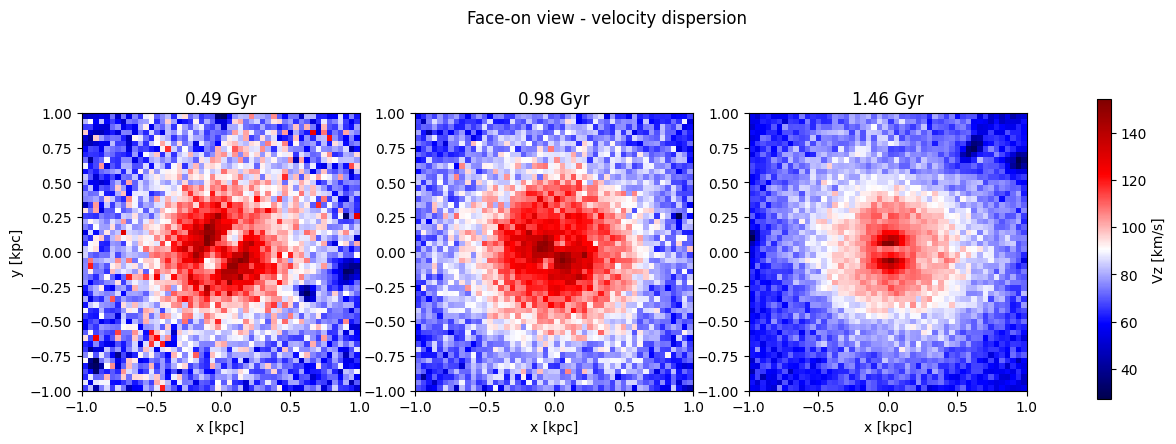

In [93]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Face-on view - velocity dispersion'
cbar_label = 'Sigma_Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Inclination 60 deg - mean velocity

In [94]:
for s in s_lst:
    s.rotate_x(-60)

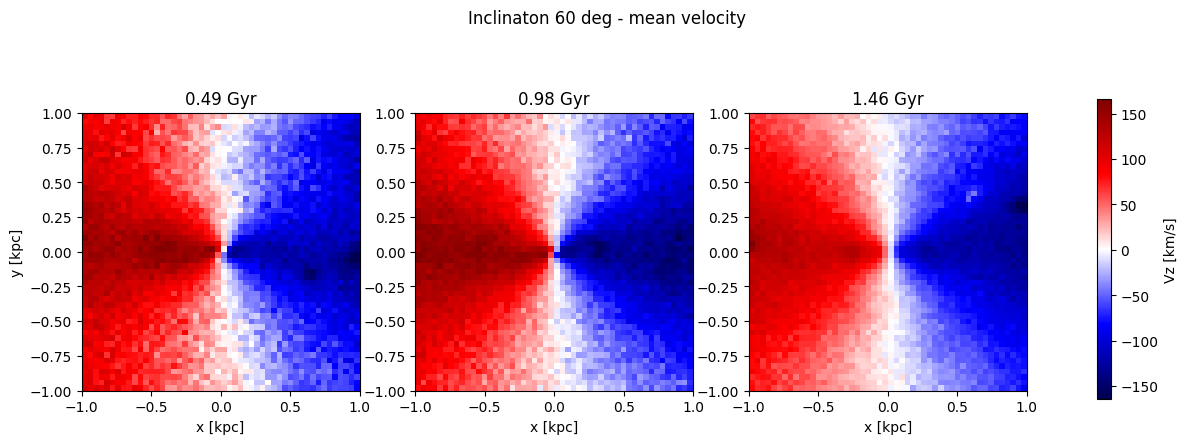

In [97]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Inclinaton 60 deg - mean velocity'
cbar_label = 'Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Inclination 60 deg - velocity dispersion

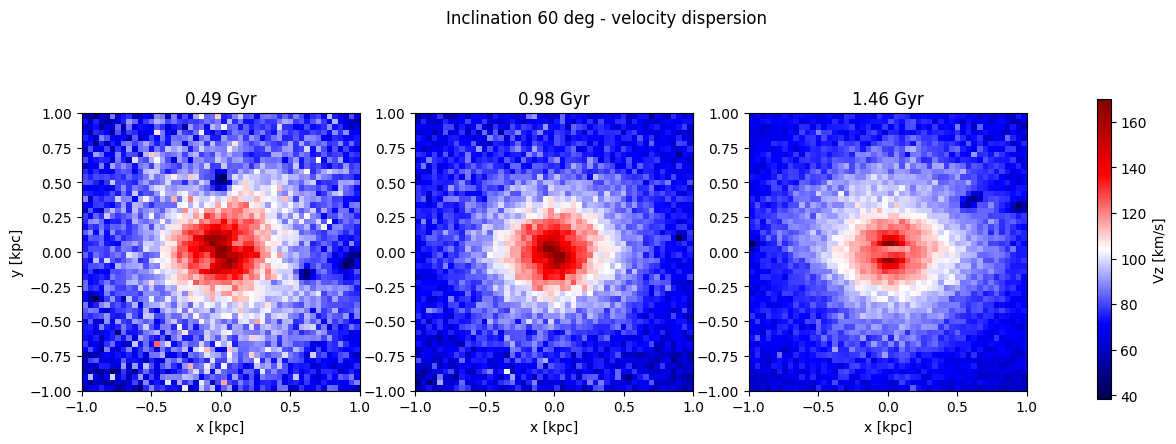

In [96]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Inclination 60 deg - velocity dispersion'
cbar_label = 'Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Edge-on - mean velocity

Rotate 90 degrees clockwise about X axis for edge-on view.
Calculate the binned velocity 2d statistics and plot.

In [98]:
for s in s_lst:
    s.rotate_x(-30)

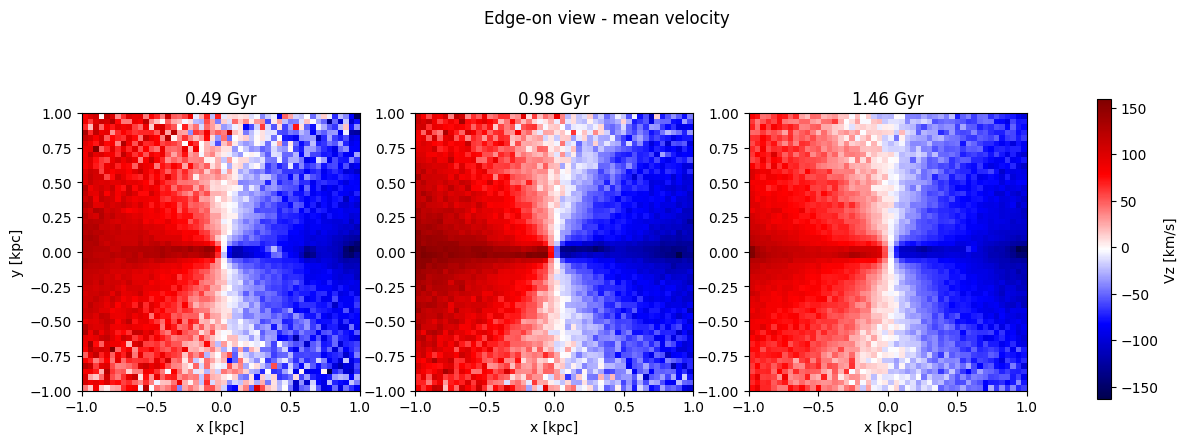

In [99]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Edge-on view - mean velocity'
cbar_label = 'Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()


#### Edge-on - velocity dispersion

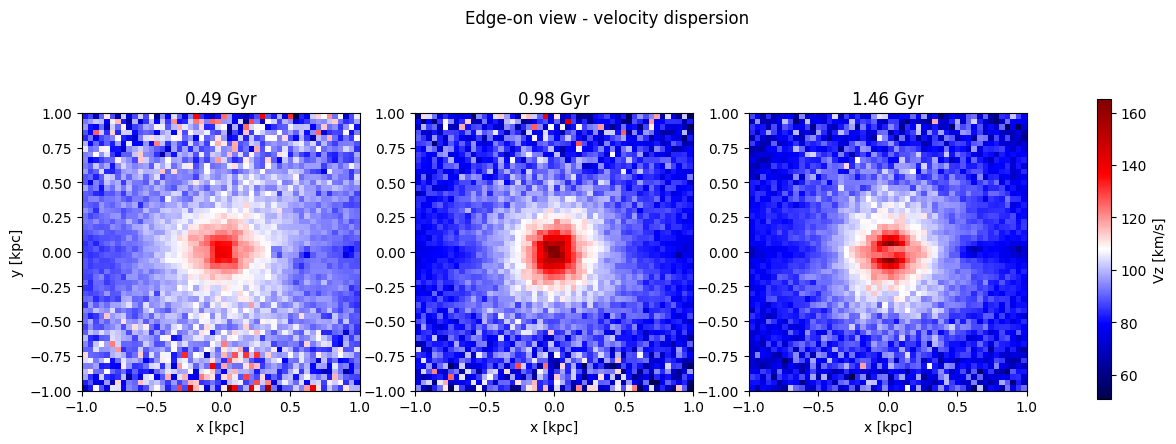

In [100]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Edge-on view - velocity dispersion'
cbar_label = 'Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()


#### Edge-on - h3

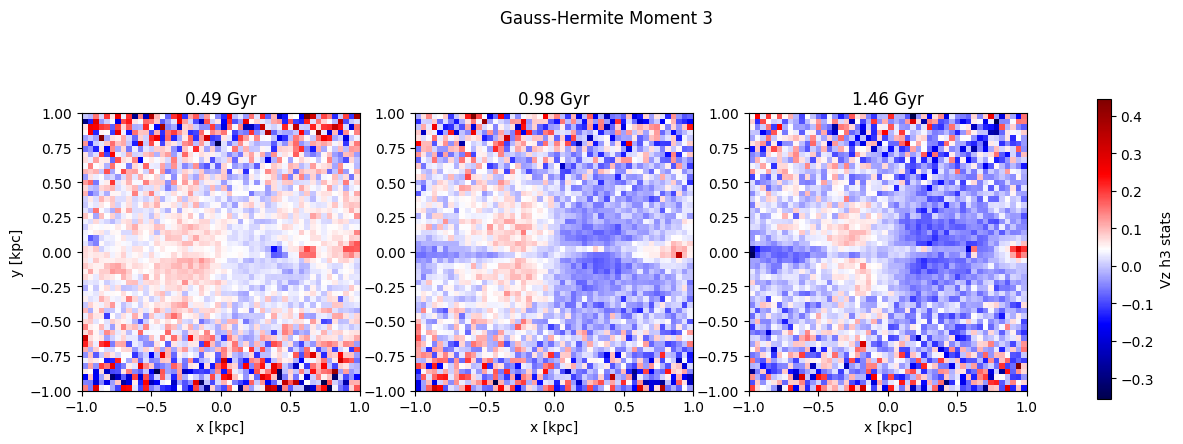

In [102]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Gauss-Hermite Moment 3'
cbar_label = 'Vz h3 stats'
m = 3

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Edge-on - h4

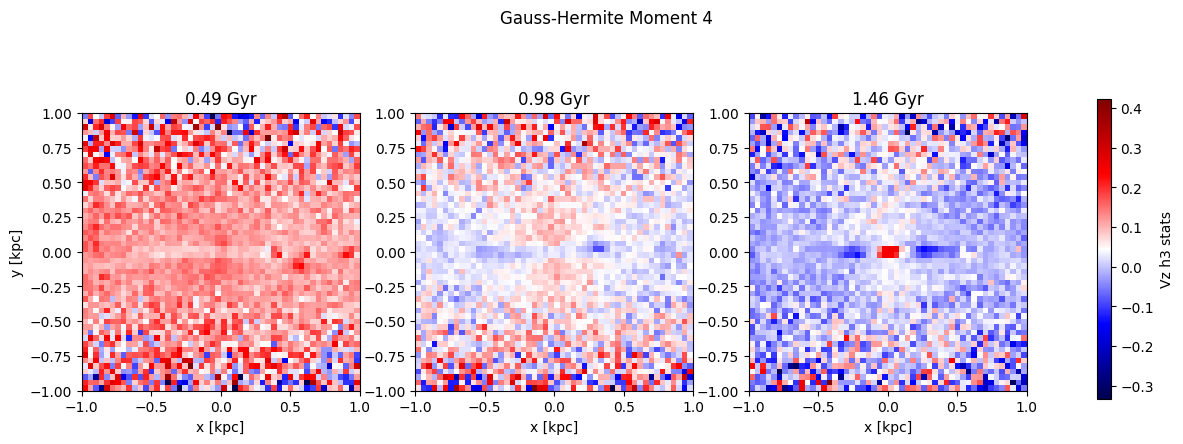

In [103]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Gauss-Hermite Moment 4'
cbar_label = 'Vz h3 stats'
m = 4

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()